In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError

from keras import backend as K
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint, EarlyStopping
import glob

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
import matplotlib.cm as cm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
# read in image and target datasets
data_path = '/content/drive/MyDrive/GalaxyZoo/compressed_img_target.npz'
loaded_arrays = np.load(data_path)

# Retrieve the arrays
train = loaded_arrays['images']
target = loaded_arrays['target']

In [ ]:
# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_temp = X_temp.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_temp = y_temp.astype('float32')
y_test = y_test.astype('float32')

# Second split to divide the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

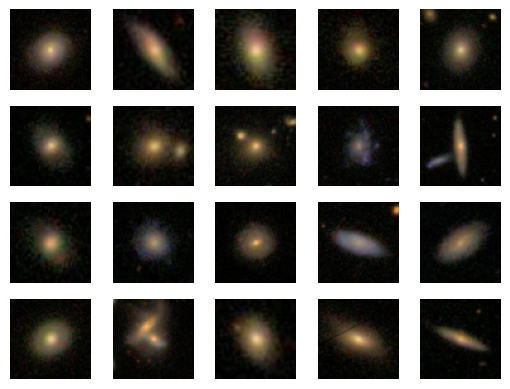

In [ ]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(train[i])
    plt.axis('off')
plt.show()

# Image augmentation

In [ ]:
# Initialising the ImageDataGenerator with specified augmentations
training_data_generator = ImageDataGenerator(
    zoom_range=0.10,  # Randomly increase or decrease the size of the image by up to 10%
    rotation_range=25,  # Randomly rotate the image between -25 to 25 degrees
    width_shift_range=0.05,  # Shift the image along its width by up to +/- 5%
    height_shift_range=0.05,  # Shift the image along its height by up to +/- 5%
    fill_mode='nearest',  # Fill in newly created pixels after a shift or rotation
)

# Creating a generator that will be used for training
train_generator = training_data_generator.flow(
    X_train, y_train,
    batch_size=128
)

# Custom CNN Architecture

In [ ]:
def custom_loss(y_true, y_pred):
    lamda = 0.001
    c1 = tf.abs(tf.reduce_sum(y_pred[:, 0:3], axis=1) - 1) # Class 1 constraint
    c2 = tf.abs(tf.reduce_sum(y_pred[:, 13:15], axis=1) - 1) # Class 6 constraint
    c3 = tf.abs((y_pred[:, 3] + y_pred[:, 4]) - y_pred[:, 1]) # Class 2 constraint
    c4 = tf.abs((y_pred[:, 15] + y_pred[:, 16] + y_pred[:, 17]) - y_pred[:, 10]) # Class 7 constraint
    c5 = tf.abs(tf.reduce_sum(y_pred[:, 18:25], axis=1) - y_pred[:, 13]) # Class 8 constraint
    c6 = tf.abs(tf.reduce_sum(y_pred[:, 25:28], axis=1) - y_pred[:, 3]) # Class 9 constraint
    c7 = tf.abs(tf.reduce_sum(y_pred[:, 5:7], axis=1) - y_pred[:, 4]) # Class 3 constraint
    c8 = tf.abs(tf.reduce_sum(y_pred[:, 7:9], axis=1) - y_pred[:, 4]) # Class 4 constraint
    c9 = tf.abs(tf.reduce_sum(y_pred[:, 28:31], axis=1) - y_pred[:, 7]) # Class 10 constraint
    c10 = tf.abs(tf.reduce_sum(y_pred[:, 9:13], axis=1) - y_pred[:, 7] - y_pred[:, 8]) # Class 5 constraint
    c11 = tf.abs(tf.reduce_sum(y_pred[:, 31:37], axis=1) - y_pred[:, 7]) # Class 11 constraint

    c_loss = lamda*(c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+c11)

    # Base loss (mean squared error)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Combine base loss with constraints (you may need to adjust the weighting)
    return mse_loss + c_loss

In [ ]:
# CNN model architecture

def parallel_cnn(input_shape, vector_size):
    input_layer = layers.Input(shape=input_shape)

    #  Path 1
    path_1 = layers.Conv2D(64, (6, 6), activation='relu', padding='same')(input_layer)
    path_1 = layers.Conv2D(64, (6, 6), activation='relu', padding='same')(path_1)
    path_1 = layers.Conv2D(128, (6, 6), activation='relu', padding='same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.MaxPooling2D((3, 3), strides=2)(path_1)
    path_1 = layers.Dropout(0.10)(path_1)

    #  Path 2
    path_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    path_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(path_2)
    path_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(path_2)
    path_2 = layers.BatchNormalization()(path_2)
    path_2 = layers.MaxPooling2D((3, 3), strides=2)(path_2)
    path_2 = layers.Dropout(0.10)(path_2)

    # Concatenation of frequency and time paths
    concatenated = layers.Concatenate(axis=-1)([path_1, path_2])

    # Convolutional layer 1 after concatenation
    concatenated = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concatenated)
    concatenated = layers.MaxPooling2D((2, 2), strides=2)(concatenated)
    concatenated = layers.Dropout(0.10)(concatenated)

    # Convolutional layer 2
    concatenated_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated)
    concatenated_2 = layers.MaxPooling2D((2, 2), strides=2)(concatenated_2)
    concatenated_2 = layers.Dropout(0.10)(concatenated_2)

    # Convolutional layer 3
    concatenated_3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated_2)
    concatenated_3 = layers.MaxPooling2D((2, 2), strides=2)(concatenated_3)
    concatenated_3 = layers.Dropout(0.10)(concatenated_3)


    # Flattening and Dense layers with regularization
    flattened = layers.Flatten()(concatenated_3)
    dense_layer = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flattened)
    dense_layer = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense_layer)
    dense_layer = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense_layer)
    dense_layer = layers.Dropout(0.2)(dense_layer)
    output_layer = layers.Dense(vector_size, activation='sigmoid')(dense_layer)

    # Model creation
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model


In [ ]:
# EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

In [ ]:
# Compiling the model
input_shape = (64, 64, 3)
vector_size = 37
cnn = parallel_cnn(input_shape, vector_size)

cnn.compile(optimizer='adam', loss = custom_loss, metrics=[RootMeanSquaredError()])
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           6976      ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           147520    ['conv2d[0][0]']              
                                                                                              

## Save weights and training history

In [ ]:
# Directory where checkpoints and history will be saved
checkpoint_dir = '/content/drive/MyDrive/GalaxyZoo/CNNcheckpoints/'
history_file = '/content/drive/MyDrive/GalaxyZoo/CNN_training_history.csv'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Callback for model checkpoints
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'cnn_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback for saving training history
csv_logger = CSVLogger(history_file, append=True)

## Train model

In [ ]:
# Training galaxy_model
history = cnn.fit(train_generator, validation_data=(X_val, y_val), epochs=300, callbacks=[checkpoint_callback, csv_logger, early_stopping_callback])

Epoch 1/300
308/308 [==============================] - ETA: 0s - loss: 0.6788 - root_mean_squared_error: 0.1857
Epoch 1: val_loss improved from inf to 0.02723, saving model to /content/drive/MyDrive/GalaxyZoo/CNNcheckpoints/cnn_epoch_01_val_loss_0.03.keras
308/308 [==============================] - 73s 186ms/step - loss: 0.6788 - root_mean_squared_error: 0.1857 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1555
Epoch 2/300
308/308 [==============================] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1533
Epoch 2: val_loss improved from 0.02723 to 0.02332, saving model to /content/drive/MyDrive/GalaxyZoo/CNNcheckpoints/cnn_epoch_02_val_loss_0.02.keras
308/308 [==============================] - 50s 162ms/step - loss: 0.0254 - root_mean_squared_error: 0.1533 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1483
Epoch 3/300
308/308 [==============================] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1457
Epoch 3: val_loss improved from 0.02332 to

In [ ]:
# Evaluate model
test_loss, test_rmse = cnn.evaluate(X_test, y_test)
print('Test RMSE:', test_rmse)

385/385 [==============================] - 4s 10ms/step - loss: 0.0106 - root_mean_squared_error: 0.0985
Test RMSE: 0.09849733114242554


# Training and validation history

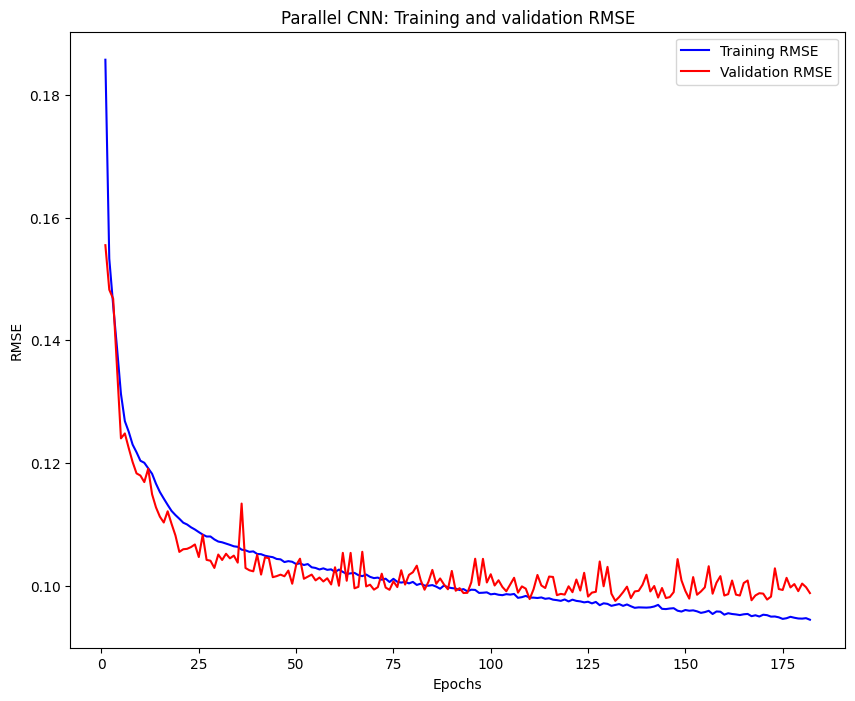

In [ ]:
history_file_path = '/content/drive/MyDrive/GalaxyZoo/CNN_training_history.csv'
training_history = pd.read_csv(history_file_path)

train_metric = training_history['root_mean_squared_error']
val_metric = training_history['val_root_mean_squared_error']
epochs = range(1, len(train_metric) + 1)

plt.figure(figsize=(10, 8))
plt.plot(epochs, train_metric, 'b', label='Training RMSE')
plt.plot(epochs, val_metric, 'r', label='Validation RMSE')
plt.title('Parallel CNN: Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('/content/drive/MyDrive/GalaxyZoo/Plots/cnn_trainval.png')
plt.show()

# Out of sample performance

In [ ]:
# Load saved model
cnn.load_weights('/content/drive/MyDrive/GalaxyZoo/CNNcheckpoints/cnn_epoch_132_val_loss_0.01.keras')

In [ ]:
# Evaluate model
test_loss, test_rmse = cnn.evaluate(X_test, y_test)
print('Test RMSE:', test_rmse)

385/385 [==============================] - 7s 10ms/step - loss: 0.0106 - root_mean_squared_error: 0.0985
Test RMSE: 0.09849733114242554


# Grad-CAM

In [ ]:
# The function 'gradcam_galaxyzoo' is defined with parameters for the image index, image dataset, model, question index, convolutional layer name, and alpha value for heatmap intensity.
def gradcam_galaxyzoo(img_index, images, model, question, last_conv_layer_name, alpha=0.5):
    """
    Execute the Grad-CAM process for a given image and model.

    Args:
    - img_index (int): Index of the image in X_train to be analyzed.
    - X_train (numpy array): The dataset containing the images.
    - model (tensorflow.keras Model): The trained model.
    - ranges (list of tuples): The ranges of prediction indices for calculating probabilities.
    - last_conv_layer_name (str): Name of the last convolutional layer in the model.
    - alpha (float, optional): Intensity factor for superimposing the heatmap. Defaults to 0.5.

    Returns:
    - Displays the original image and the image with Grad-CAM heatmap.
    """
    
    img_array = train[img_index:img_index+1]  # Select an image
    img_array = img_array.astype('float32') / 255 # Convert the image to float32 and normalize
    preds = model.predict(img_array)  # Generate predictions for the selected image

    # This nested function calculates a heatmap by computing gradients of the targeted class output relative to the outputs of the last convolutional layer.
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    # Define ranges for the questions
    ranges = [(1, 3), (4, 5), (6, 7), (8, 9), (10, 13),(14, 15), (16, 18), (19, 25), (26, 28), (29, 31), (32, 37)]

    # This function calculates maximum probabilities within specified ranges of model predictions.
    def calculate_range_probabilities(preds, ranges):
        range_probs = []
        for start, end in ranges:
            range_max = tf.reduce_max(preds[0, start-1:end])
            range_probs.append(((start, end), range_max.numpy()))
        return range_probs

    # The function applies a color map to the heatmap and blends it with the original image using the given alpha transparency.
    def superimpose_image_and_heatmap(img, heatmap, alpha=0.5):
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = array_to_img(jet_heatmap).resize((img.shape[1], img.shape[0]))
        jet_heatmap = img_to_array(jet_heatmap)
        superimposed_img = jet_heatmap * alpha + img
        return np.clip(superimposed_img, 0, 255).astype('uint8')

    # The function selects a specific prediction range based on the question index and determines the class index with the highest probability within that range.
    range_probabilities = calculate_range_probabilities(preds, ranges)
    selected_range = ranges[question]
    selected_probs = preds[0, selected_range[0]-1:selected_range[1]]
    pred_index_within_range = np.argmax(selected_probs) + (selected_range[0]-1)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index_within_range)
    original_img = train[img_index].astype('uint8')
    superimposed_img = superimpose_image_and_heatmap(original_img, heatmap, alpha=alpha)

    # Generates the Grad-CAM heatmap, retrieves the original image, superimposes the heatmap, and displays both the original and modified images.
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[1].imshow(array_to_img(superimposed_img))
    ax[1].set_title('Image with Grad-CAM')
    plt.show()

### Image 1: Question 1 (Is the galaxy simply smooth/rounded, or a disk, or a star/artifact?)

1/1 [==============================] - 0s 37ms/step


<ipython-input-89-033faa43cbb6>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


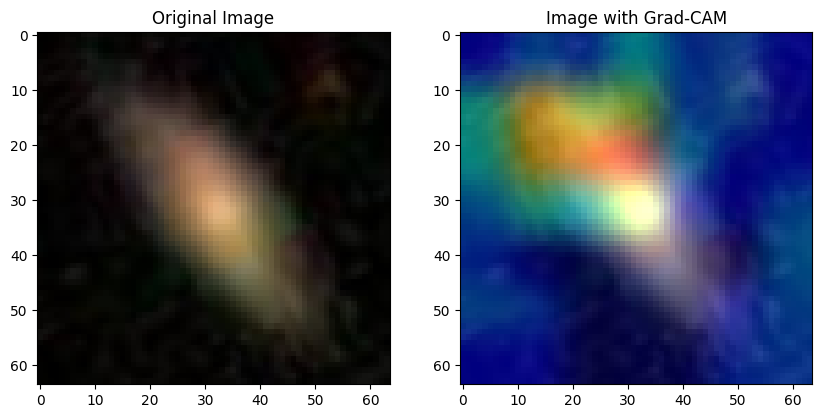

In [ ]:
gradcam_galaxyzoo(img_index=1, images=train, model=cnn, question=0, last_conv_layer_name='conv2d_8')

### Image 1: Question 2 (Could this be a disk viewed edged on?)

1/1 [==============================] - 0s 38ms/step


<ipython-input-89-033faa43cbb6>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


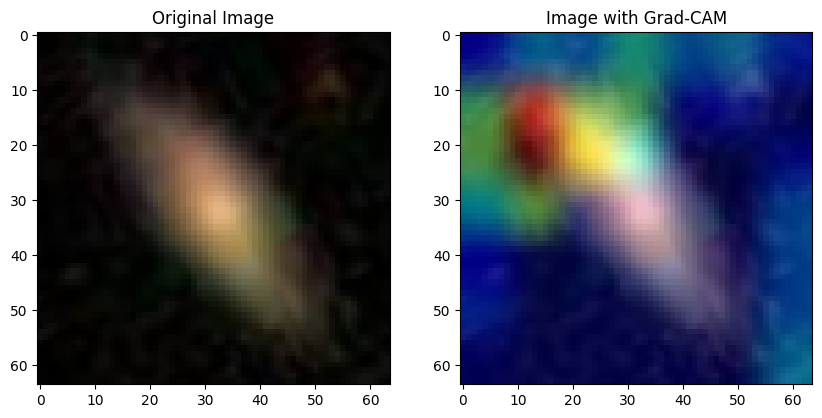

In [ ]:
gradcam_galaxyzoo(img_index=1, images=train, model=cnn, question=1, last_conv_layer_name='conv2d_8')